In [1]:
!pip install ultralytics -q

import os, shutil, zipfile, glob, yaml
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    print("GPU: None")

from ultralytics import YOLO

PyTorch version: 2.8.0+cu126
CUDA available: True
GPU: Tesla T4


In [2]:
from google.colab import drive
drive.mount('/content/drive')

print("\n" + "="*80)
print("UAV-BASED WEED SPECIES DETECTION DATASET")
print("="*80)
print("""
Dataset Overview:
- Source: UAV imagery from agricultural fields in Spain
- Crops: Maize (Corn) and Tomato
- Camera: Sony ILCE-6300L at 11m altitude
- Total Images: ~67,000 RGB images (JPG format)
- Growth Stages: Early (BBCH14 maize, BBCH501 tomato) & Later (BBCH17 maize, BBCH509 tomato)
- Weed Species:
  -- Maize: Atriplex patula, Chenopodium album, Convolvulus arvensis, Datura ferox, Lolium rigidum, Salsola kali, Sorghum halepense
  -- Tomato: Cyperus rotundus, Portulaca oleracea, Solanum nigrum
Purpose: Early-stage weed detection for precision agriculture and targeted control measures.
""")
print("="*80 + "\n")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

UAV-BASED WEED SPECIES DETECTION DATASET

Dataset Overview:
- Source: UAV imagery from agricultural fields in Spain
- Crops: Maize (Corn) and Tomato
- Camera: Sony ILCE-6300L at 11m altitude
- Total Images: ~67,000 RGB images (JPG format)
- Growth Stages: Early (BBCH14 maize, BBCH501 tomato) & Later (BBCH17 maize, BBCH509 tomato)
- Weed Species:
  -- Maize: Atriplex patula, Chenopodium album, Convolvulus arvensis, Datura ferox, Lolium rigidum, Salsola kali, Sorghum halepense
  -- Tomato: Cyperus rotundus, Portulaca oleracea, Solanum nigrum
Purpose: Early-stage weed detection for precision agriculture and targeted control measures.




In [3]:
ZIP_FILE_PATH = '/content/drive/MyDrive/ML_MV_Dataset.zip'
EXTRACT_PATH = '/content/extracted_dataset'
os.makedirs(EXTRACT_PATH, exist_ok=True)

print("Extracting main dataset archive...")
with zipfile.ZipFile(ZIP_FILE_PATH, 'r') as zip_ref:
    zip_ref.extractall(EXTRACT_PATH)
print(f"Main archive extracted to: {EXTRACT_PATH}")

def extract_all_nested_zips(directory):
    zip_files = list(Path(directory).rglob('*.zip'))
    valid_zips = [z for z in zip_files if not z.name.startswith('._')]
    print(f"Found {len(valid_zips)} valid ZIP files for extraction.")
    for zip_path in valid_zips:
        print(f"  Extracting: {zip_path.relative_to(directory)}")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(zip_path.parent)
extract_all_nested_zips(EXTRACT_PATH)

# Remove MacOS-specific directories if found
cleaned_dirs = 0
for root, dirs, files in os.walk(EXTRACT_PATH):
    if '__MACOSX' in dirs:
        shutil.rmtree(os.path.join(root, '__MACOSX'))
        cleaned_dirs += 1
if cleaned_dirs > 0:
    print(f"Removed {cleaned_dirs} __MACOSX directories.")
else:
    print("No __MACOSX directories were found.")

DATASET_PATH = os.path.join(EXTRACT_PATH, 'ML_MV_Dataset')
print("\nDataset extraction complete!")

Extracting main dataset archive...
Main archive extracted to: /content/extracted_dataset
Found 24 valid ZIP files for extraction.
  Extracting: ML_MV_Dataset/Maize_1/maize_1_convolvulus.zip
  Extracting: ML_MV_Dataset/Maize_1/maize_1_sorghum.zip
  Extracting: ML_MV_Dataset/Maize_1/maize_1_lolium.zip
  Extracting: ML_MV_Dataset/Maize_1/maize_1_datura.zip
  Extracting: ML_MV_Dataset/Maize_1/maize_1_chenopodium.zip
  Extracting: ML_MV_Dataset/Maize_1/maize_1_atriplex.zip
  Extracting: ML_MV_Dataset/Maize_1/maize_1_salsola.zip
  Extracting: ML_MV_Dataset/Maize_1/maize_1.zip
  Extracting: ML_MV_Dataset/Maize_2/maize_2.zip
  Extracting: ML_MV_Dataset/Maize_2/maize_2_atriplex.zip
  Extracting: ML_MV_Dataset/Maize_2/maize_2_salsola.zip
  Extracting: ML_MV_Dataset/Maize_2/maize_2_convolvulus.zip
  Extracting: ML_MV_Dataset/Maize_2/maize_2_lolium.zip
  Extracting: ML_MV_Dataset/Maize_2/maize_2_chenopodium.zip
  Extracting: ML_MV_Dataset/Maize_2/maize_2_datura.zip
  Extracting: ML_MV_Dataset/Maiz

In [4]:
# Gather valid image files from all subfolders
all_images = []
for ext in ("jpg", "JPG", "png"):
    all_images.extend(glob.glob(f'{DATASET_PATH}/**/*.{ext}', recursive=True))
# Remove hidden or MacOS files
all_images = [img for img in all_images if '__MACOSX' not in img and not os.path.basename(img).startswith('._') and os.path.exists(img)]
print(f"Total valid images found: {len(all_images)}")

# Compute class/crop/stage distribution for a high-level view
class_distribution, crop_distribution, stage_distribution = {}, {"Maize": 0, "Tomato": 0}, {}
for img_path in all_images:
    path_parts = Path(img_path).parts
    folder_name = Path(img_path).parent.name
    # Crop assignment (for info only)
    if 'maize' in folder_name.lower():
        crop_distribution["Maize"] += 1
    elif 'tomato' in folder_name.lower():
        crop_distribution["Tomato"] += 1
    # Class distribution
    class_distribution.setdefault(folder_name, []).append(img_path)
    # Stage (not used in labeling, just info)
    if '1' in folder_name:
        stage_distribution["Early Stage"] = stage_distribution.get("Early Stage", 0) + 1
    elif '2' in folder_name:
        stage_distribution["Later Stage"] = stage_distribution.get("Later Stage", 0) + 1

print(f"\nCrop Distribution:\n{crop_distribution}")
print(f"Stage Distribution:\n{stage_distribution}")
print(f"Top classes by image count:")
for folder, images in sorted(class_distribution.items(), key=lambda x: len(x[1]), reverse=True)[:10]:
    print(f"  {folder}: {len(images)} images")

Total valid images found: 67346

Crop Distribution:
{'Maize': 51373, 'Tomato': 15973}
Stage Distribution:
{'Early Stage': 30931, 'Later Stage': 36415}
Top classes by image count:
  maize_2: 24473 images
  maize_1: 12318 images
  tomato_1: 3890 images
  tomato_1_cyperus: 3090 images
  tomato_2: 2732 images
  tomato_2_solanum: 2184 images
  maize_2_chenopodium: 2175 images
  tomato_1_solanum: 1900 images
  tomato_1_portulaca: 1875 images
  maize_1_sorghum: 1600 images


In [5]:
# Define your weed/crop class names exactly as you want them
maize_weeds = ['atriplex', 'chenopodium', 'convolvulus', 'datura', 'lolium', 'salsola', 'sorghum']
tomato_weeds = ['cyperus', 'portulaca', 'solanum']
crops = ['maize', 'tomato']
class_names = crops + maize_weeds + tomato_weeds
class_to_id = {name: idx for idx, name in enumerate(class_names)}

print("\nDetected classes:")
for idx, name in enumerate(class_names):
    print(f"  {idx}: {name}")


Detected classes:
  0: maize
  1: tomato
  2: atriplex
  3: chenopodium
  4: convolvulus
  5: datura
  6: lolium
  7: salsola
  8: sorghum
  9: cyperus
  10: portulaca
  11: solanum


In [6]:
def get_pure_class(label_folder):
    """
    Extracts pure class name by matching the provided folder against the defined class_names.
    Returns the first match found (priority: more specific weeds, then crops).
    """
    fname = label_folder.lower()
    for cname in maize_weeds + tomato_weeds:
        if cname in fname:
            return cname
    for cname in crops:
        if fname.startswith(cname):
            return cname
    return None

valid_pairs = []
for img_path in all_images:
    folder_name = Path(img_path).parent.name
    pure_class = get_pure_class(folder_name)
    if pure_class and pure_class in class_to_id:
        valid_pairs.append((img_path, class_to_id[pure_class], pure_class))

print(f"\nValid images with assigned classes: {len(valid_pairs)}")
class_counts = {}
for _, _, cname in valid_pairs:
    class_counts[cname] = class_counts.get(cname, 0) + 1
print("Sample per-class distribution:")
for cname in class_names:
    print(f"  {cname}: {class_counts.get(cname, 0)} images")


Valid images with assigned classes: 67346
Sample per-class distribution:
  maize: 36791 images
  tomato: 6622 images
  atriplex: 2459 images
  chenopodium: 3375 images
  convolvulus: 2302 images
  datura: 1271 images
  lolium: 1063 images
  salsola: 2409 images
  sorghum: 1703 images
  cyperus: 3215 images
  portulaca: 2052 images
  solanum: 4084 images


In [7]:
train_pairs, temp_pairs = train_test_split(
    valid_pairs, test_size=0.3, random_state=42,
    stratify=[p[2] for p in valid_pairs]
)
val_pairs, test_pairs = train_test_split(
    temp_pairs, test_size=0.5, random_state=42,
    stratify=[p[2] for p in temp_pairs]
)
print(f"\nDataset split:")
print(f"  Training:   {len(train_pairs)}")
print(f"  Validation: {len(val_pairs)}")
print(f"  Testing:    {len(test_pairs)}")


Dataset split:
  Training:   47142
  Validation: 10102
  Testing:    10102


In [8]:
WORK_DIR = '/content/weed_detection'
dataset_dir = f'{WORK_DIR}/dataset'
for split in ['train', 'val', 'test']:
    for class_name in class_names:
        os.makedirs(f'{dataset_dir}/images/{split}/{class_name}', exist_ok=True)

def copy_for_classification(pairs, split):
    for img_path, class_id, class_name in pairs:
        basename = Path(img_path).stem + Path(img_path).suffix
        dest = f'{dataset_dir}/images/{split}/{class_name}/{basename}'
        if not os.path.exists(dest):
            shutil.copy2(img_path, dest)
    print(f"Copied {len(pairs)} images to {split} set.")

copy_for_classification(train_pairs, 'train')
copy_for_classification(val_pairs, 'val')
copy_for_classification(test_pairs, 'test')

Copied 47142 images to train set.
Copied 10102 images to val set.
Copied 10102 images to test set.


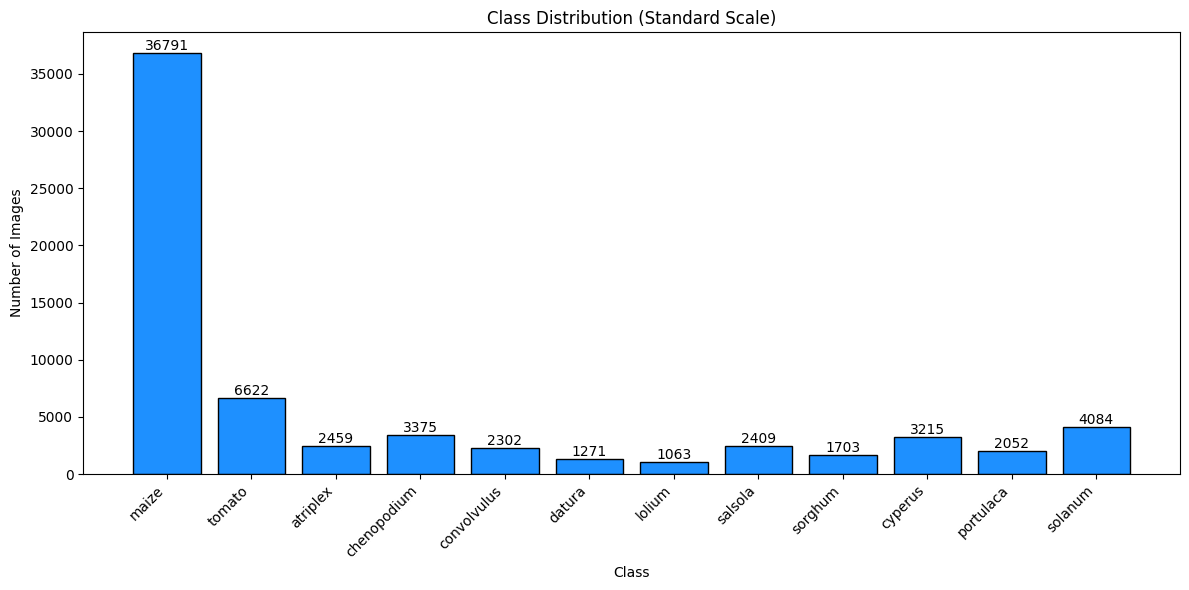

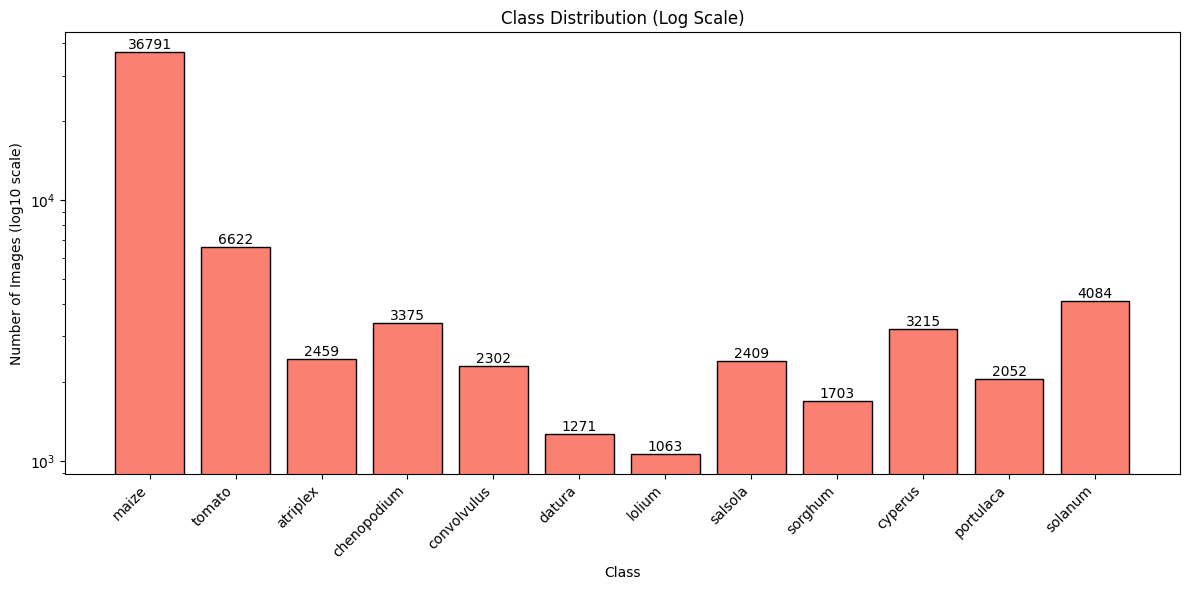

Graphs saved in /content/weed_detection/class_balance_visuals


In [9]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import os
from datetime import datetime

# Prepare output directory
VIS_DIR = '/content/weed_detection/class_balance_visuals'
os.makedirs(VIS_DIR, exist_ok=True)

# Build class sample counts from valid_pairs
class_counts = Counter([p[2] for p in valid_pairs])

# Use the order in class_names for the bars
class_labels = class_names
class_freqs = [class_counts.get(c, 0) for c in class_labels]

# Timestamp for saving outputs
now = datetime.now().strftime('%Y-%m-%d_%H-%M')

# Bar chart: standard y-axis
plt.figure(figsize=(12,6))
bars = plt.bar(class_labels, class_freqs, color="dodgerblue", edgecolor="black")
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution (Standard Scale)')
plt.xticks(rotation=45, ha='right')
# Add value labels
for bar, freq in zip(bars, class_freqs):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(freq), ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.savefig(f'{VIS_DIR}/class_distribution_standard_{now}.png', dpi=150)
plt.show()

# Bar chart: log y-axis
plt.figure(figsize=(12,6))
bars = plt.bar(class_labels, class_freqs, color="salmon", edgecolor="black")
plt.xlabel('Class')
plt.ylabel('Number of Images (log10 scale)')
plt.title('Class Distribution (Log Scale)')
plt.yscale('log')
plt.xticks(rotation=45, ha='right')
for bar, freq in zip(bars, class_freqs):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(freq), ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.savefig(f'{VIS_DIR}/class_distribution_log_{now}.png', dpi=150)
plt.show()

print(f"Graphs saved in {VIS_DIR}")

In [10]:
import glob
import random
import os
import matplotlib.pyplot as plt
from collections import Counter

# Define paths and get class names (assuming 'class_names' is from the previous cell)
base_train_dir = '/content/weed_detection/dataset/images/train'

# Re-scan class names from the directory structure to be certain
class_names = [d for d in os.listdir(base_train_dir) if os.path.isdir(os.path.join(base_train_dir, d))]
class_names.sort() # Ensure consistent order

print("--- Before Undersampling (Training Set) ---")
# Get counts for each class in the training set
train_counts = {}
for cname in class_names:
    image_files = glob.glob(f'{base_train_dir}/{cname}/*')
    train_counts[cname] = len(image_files)

# Sort counts to find majority and second-largest
sorted_counts = sorted(train_counts.items(), key=lambda x: x[1], reverse=True)
for cname, count in sorted_counts:
    print(f"  {cname}: {count} images")

# Determine undersampling target
if sorted_counts:
    majority_class, majority_count = sorted_counts[0]
    target_class, target_count = sorted_counts[1] # Second-largest class

    print(f"\nTarget: Downsampling majority class '{majority_class}' ({majority_count})")
    print(f"to match second-largest class '{target_class}' ({target_count}).")

    # Get all image paths for the majority class
    majority_images = glob.glob(f'{base_train_dir}/{majority_class}/*')

    # Randomly select images to *keep*
    images_to_keep = set(random.sample(majority_images, target_count))

    # Find images to *delete*
    images_to_delete = [img for img in majority_images if img not in images_to_keep]

    print(f"Deleting {len(images_to_delete)} images from '{majority_class}'...")
    # Delete the excess images
    deleted_count = 0
    for img_path in images_to_delete:
        try:
            os.remove(img_path)
            deleted_count += 1
        except OSError as e:
            print(f"Error deleting {img_path}: {e}")

    print(f"Successfully deleted {deleted_count} images.")
else:
    print("No classes found in training directory.")


print("\n--- After Undersampling (Training Set) ---")
# Get new counts
new_train_counts = {}
for cname in class_names:
    new_train_counts[cname] = len(glob.glob(f'{base_train_dir}/{cname}/*'))

for cname, count in sorted(new_train_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"  {cname}: {count} images")

# Store new counts for visualization
balanced_class_labels = list(new_train_counts.keys())
balanced_class_freqs = list(new_train_counts.values())

--- Before Undersampling (Training Set) ---
  maize: 25754 images
  tomato: 4635 images
  solanum: 2859 images
  chenopodium: 2363 images
  cyperus: 2251 images
  atriplex: 1721 images
  salsola: 1686 images
  convolvulus: 1611 images
  portulaca: 1436 images
  sorghum: 1192 images
  datura: 890 images
  lolium: 744 images

Target: Downsampling majority class 'maize' (25754)
to match second-largest class 'tomato' (4635).
Deleting 21119 images from 'maize'...
Successfully deleted 21119 images.

--- After Undersampling (Training Set) ---
  maize: 4635 images
  tomato: 4635 images
  solanum: 2859 images
  chenopodium: 2363 images
  cyperus: 2251 images
  atriplex: 1721 images
  salsola: 1686 images
  convolvulus: 1611 images
  portulaca: 1436 images
  sorghum: 1192 images
  datura: 890 images
  lolium: 744 images


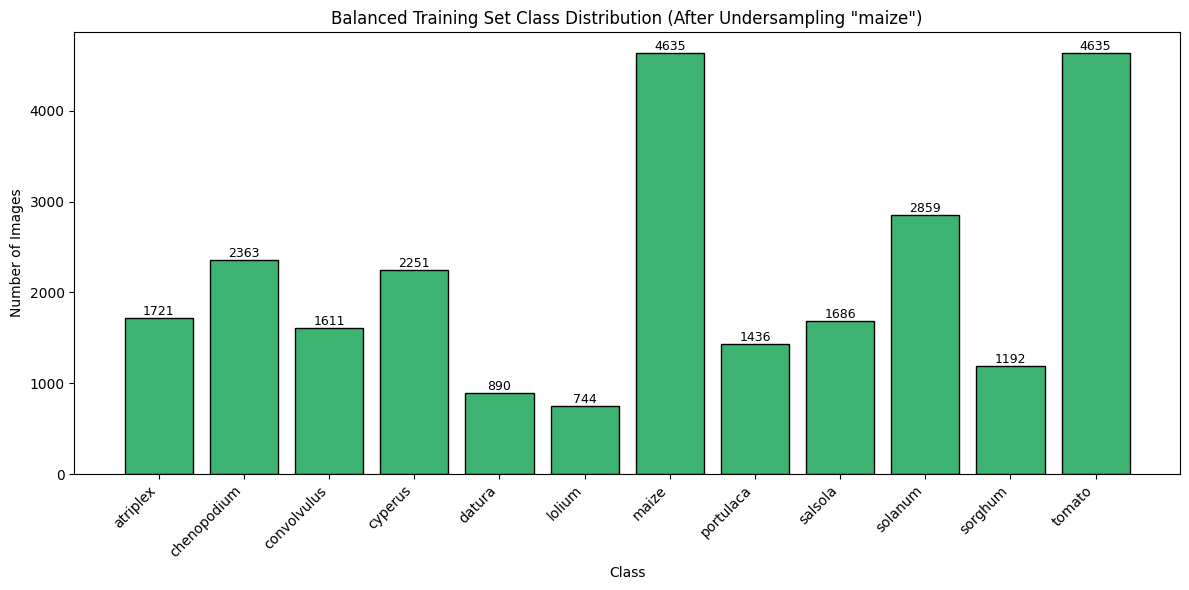

In [11]:
plt.figure(figsize=(12,6))
bars = plt.bar(balanced_class_labels, balanced_class_freqs, color="mediumseagreen", edgecolor="black")
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Balanced Training Set Class Distribution (After Undersampling "maize")')
plt.xticks(rotation=45, ha='right')

# Add value labels
for bar, freq in zip(bars, balanced_class_freqs):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(freq), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [12]:
from ultralytics import YOLO

# Define the root dataset directory
# This directory contains the 'train', 'val', and 'test' subfolders
DATASET_ROOT_PATH = '/content/weed_detection/dataset/images'

# Load the pretrained YOLOv8n-cls model
model = YOLO('yolov8n-cls.pt')

# Define training parameters
EPOCHS = 5
BATCH_SIZE = 64
PROJECT_NAME = 'weed_classification'
RUN_NAME = 'yolov8n_cls_finetune_balanced'

print("--- 🚀 Starting Model Training ---")
print(f"  Model: yolov8n-cls.pt (pretrained)")
print(f"  Data Path: {DATASET_ROOT_PATH}")
print(f"  Image Size: 224x224")
print(f"  Epochs: {EPOCHS}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Project: {PROJECT_NAME}")
print("---------------------------------")

# Train the model
# The 'data' argument points to the root of our dataset
results = model.train(
    data=DATASET_ROOT_PATH,
    imgsz=224,
    epochs=EPOCHS,
    batch=BATCH_SIZE,
    project=PROJECT_NAME,
    name=RUN_NAME,
    exist_ok=True,  # Overwrite previous runs with the same name if any
    patience=5      # Stop training if val_accuracy doesn't improve for 5 epochs
)

print("\n--- ✅ Training Complete ---")
print(f"Results and weights saved to: {results.save_dir}")

--- 🚀 Starting Model Training ---
  Model: yolov8n-cls.pt (pretrained)
  Data Path: /content/weed_detection/dataset/images
  Image Size: 224x224
  Epochs: 5
  Batch Size: 64
  Project: weed_classification
---------------------------------
Ultralytics 8.3.227 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=64, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/weed_detection/dataset/images, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=

Loading results from: /content/weed_classification/yolov8n_cls_finetune_balanced

--- 📈 Training & Validation Metrics Plot ---


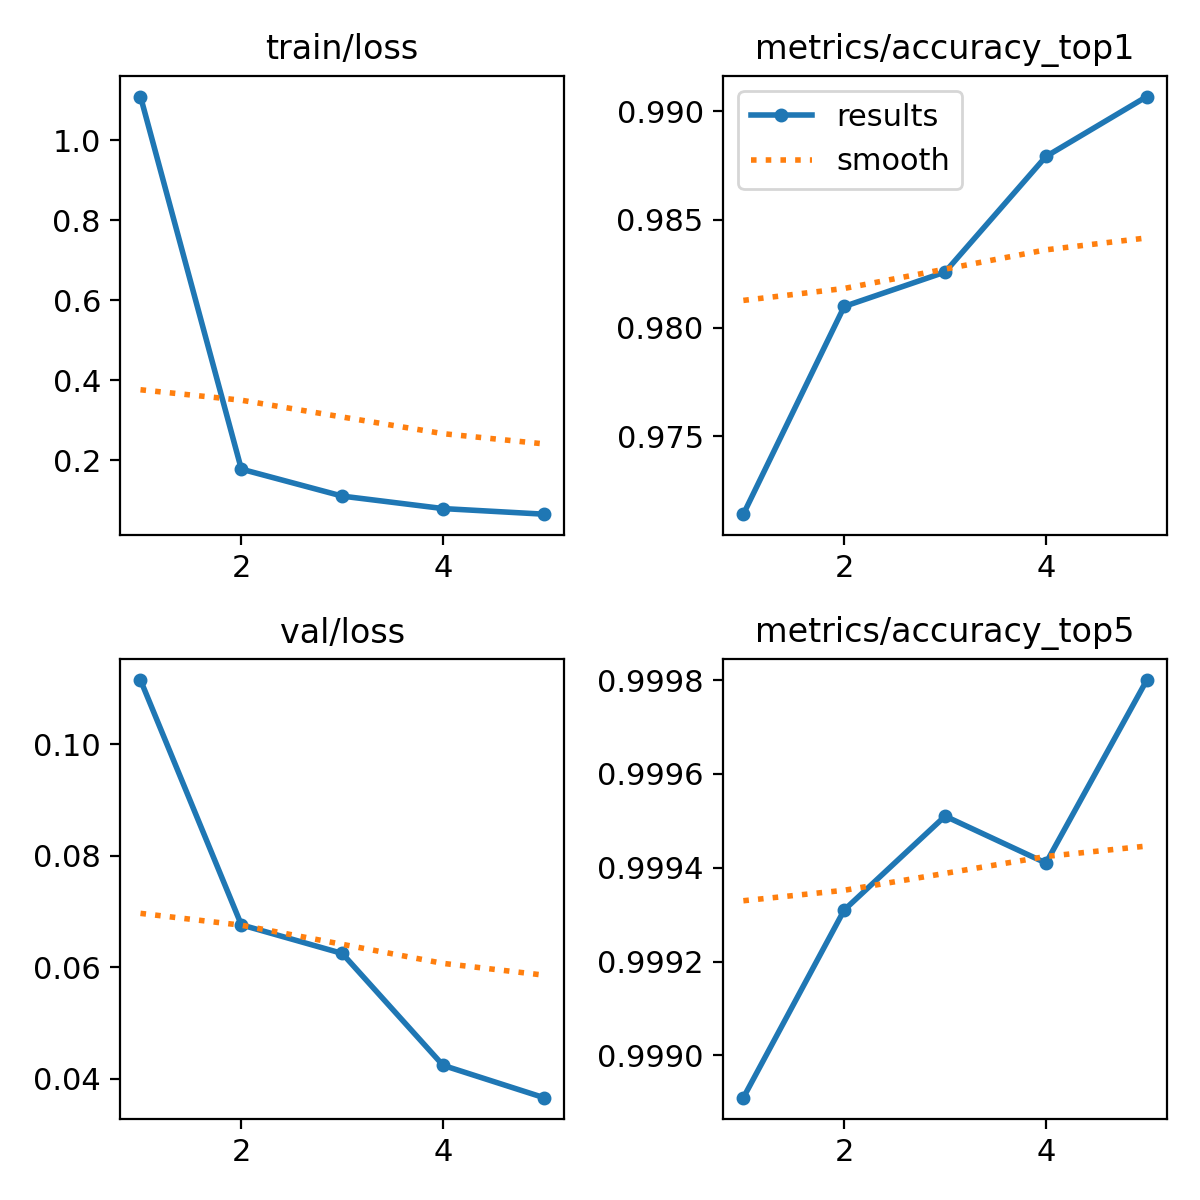


--- 📊 Confusion Matrix (Validation Set) ---


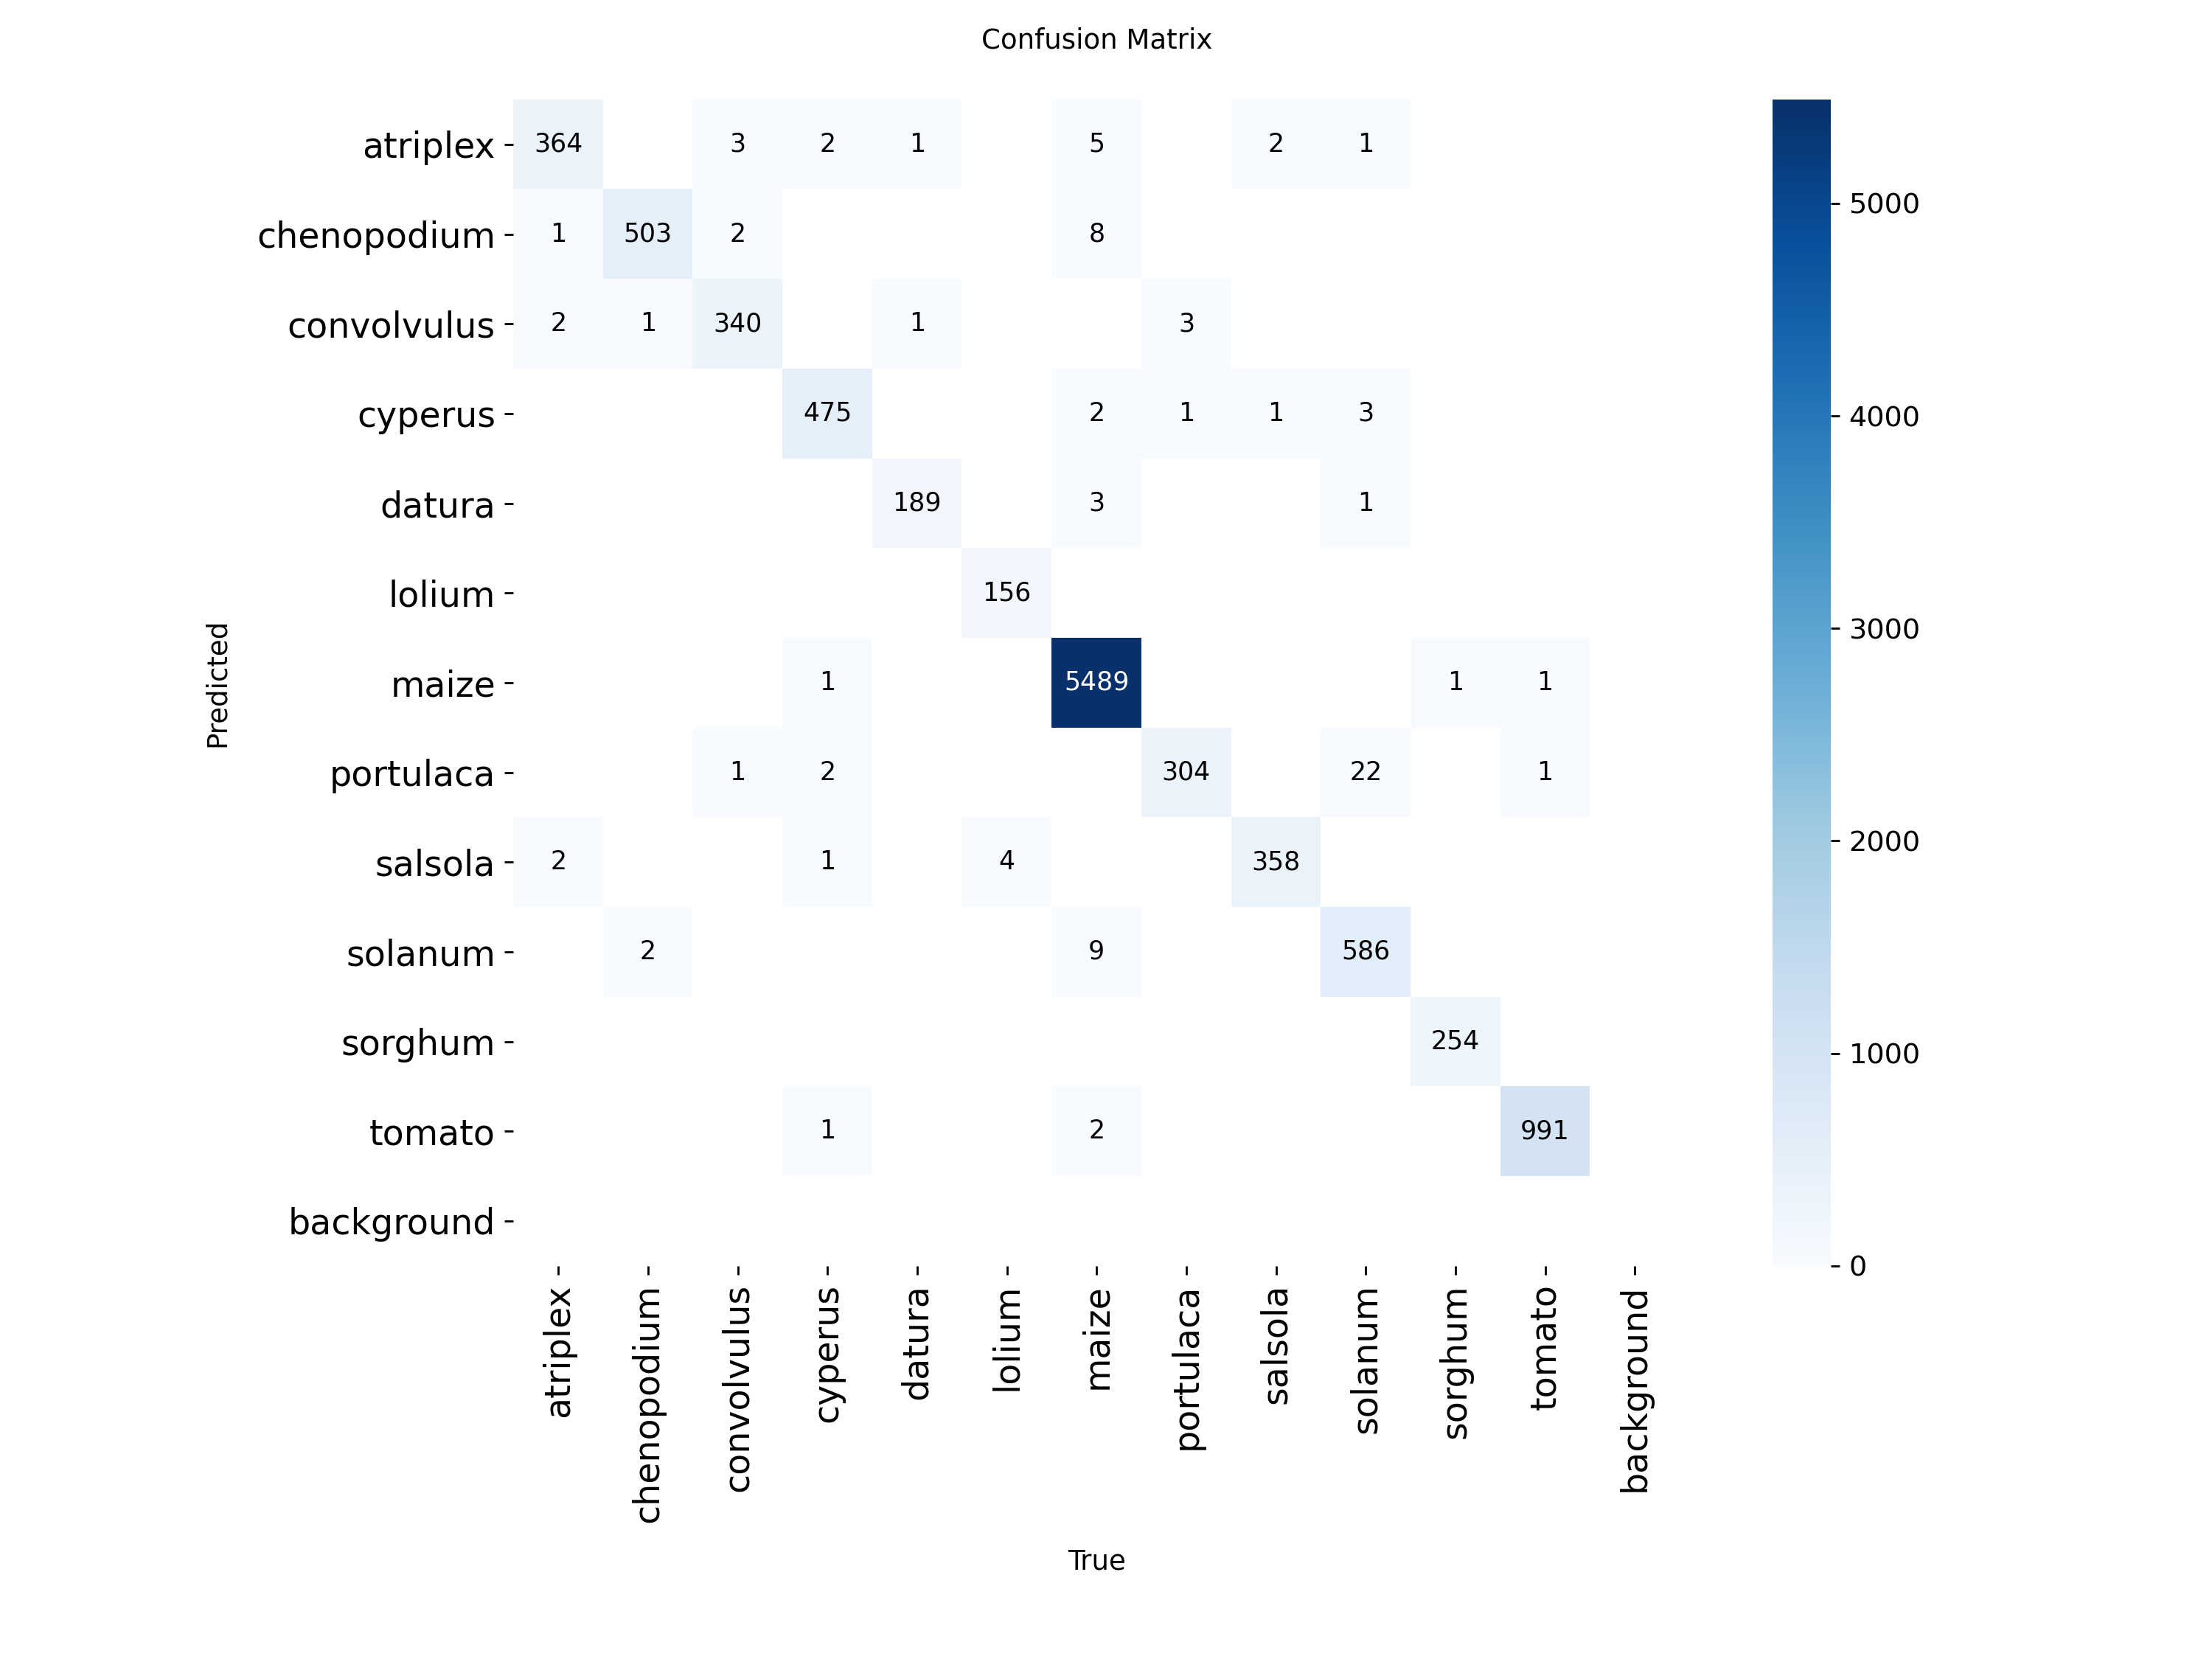

In [13]:
from IPython.display import Image, display

# The 'results' object from train() contains the save directory
training_run_dir = results.save_dir

print(f"Loading results from: {training_run_dir}\n")

# Display the main results chart (loss, accuracy vs. epoch)
print("--- 📈 Training & Validation Metrics Plot ---")
results_plot_path = os.path.join(training_run_dir, 'results.png')
if os.path.exists(results_plot_path):
    display(Image(filename=results_plot_path))
else:
    print(f"Could not find results.png at {results_plot_path}")

# Display the confusion matrix (from the last epoch's validation)
print("\n--- 📊 Confusion Matrix (Validation Set) ---")
cm_plot_path = os.path.join(training_run_dir, 'confusion_matrix.png')
if os.path.exists(cm_plot_path):
    display(Image(filename=cm_plot_path))
else:
    print(f"Could not find confusion_matrix.png at {cm_plot_path}")

In [14]:
print("--- 🏆 Final Model Evaluation ---")

# This assumes 'training_run_dir' is in memory from the previous cell
best_model_path = os.path.join(training_run_dir, 'weights/best.pt')

if not os.path.exists(best_model_path):
    print(f"Error: Could not find best model at {best_model_path}")
    print("Using the 'last' model instead.")
    best_model_path = os.path.join(training_run_dir, 'weights/last.pt')

print(f"Loading best model from: {best_model_path}")
best_model = YOLO(best_model_path)

# --- Evaluate on Validation Set ---
print("\n--- Validating on 'val' set ---")
val_metrics = best_model.val(
    data=DATASET_ROOT_PATH, # Assumes DATASET_ROOT_PATH is in memory
    split='val',
    imgsz=224
)

print(f"\nValidation Accuracy (Top-1): {val_metrics.top1:.4f}")
print(f"Validation Accuracy (Top-5): {val_metrics.top5:.4f}")

# --- Evaluate on Test Set ---
print("\n--- Validating on 'test' set (Final Performance) ---")
test_metrics = best_model.val(
    data=DATASET_ROOT_PATH, # Assumes DATASET_ROOT_PATH is in memory
    split='test',
    imgsz=224
)

print(f"\nTest Accuracy (Top-1): {test_metrics.top1:.4f}")
print(f"Test Accuracy (Top-5): {test_metrics.top5:.4f}")

print("\n--- High-Level Evaluation Complete ---")
print("Proceeding to detailed metrics calculation...")

--- 🏆 Final Model Evaluation ---
Loading best model from: /content/weed_classification/yolov8n_cls_finetune_balanced/weights/best.pt

--- Validating on 'val' set ---
Ultralytics 8.3.227 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n-cls summary (fused): 30 layers, 1,450,252 parameters, 0 gradients, 3.3 GFLOPs
train: /content/weed_detection/dataset/images/train... found 26023 images in 12 classes ✅ 
val: /content/weed_detection/dataset/images/val... found 10102 images in 12 classes ✅ 
test: /content/weed_detection/dataset/images/test... found 10102 images in 12 classes ✅ 
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 85.6±35.4 MB/s, size: 2.2 KB)
val: Scanning /content/weed_detection/dataset/images/val... 10102 images, 0 corrupt: 100% ━━━━━━━━━━━━ 10102/10102 20.4Mit/s 0.0s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 632/632 23.9it/s 26.5s
                   all      0.991          1
Speed: 0.1ms preprocess, 0.7ms inference, 0.0ms loss, 0.

In [15]:
import glob
from pathlib import Path
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

print("--- 🚀 Starting New Detailed Test Evaluation ---")

# --- 1. Gather All Test Files and True Labels ---
# (This part is fast and memory-light)

# Assumes DATASET_ROOT_PATH and best_model are in memory
test_dir = os.path.join(DATASET_ROOT_PATH, 'test')
class_names = list(best_model.names.values())
class_to_id = {name: idx for idx, name in best_model.names.items()}

print(f"Found {len(class_names)} classes: {class_names}")

all_test_paths = []
y_true_list = []

for class_name in class_names:
    class_dir = os.path.join(test_dir, class_name)
    images = glob.glob(os.path.join(class_dir, '*'))
    all_test_paths.extend(images)
    y_true_list.extend([class_to_id[class_name]] * len(images))

print(f"Gathered {len(all_test_paths)} total test images.")

# --- 2. Process Predictions in Controlled Batches ---
# This is the new, memory-safe part

BATCH_SIZE = 128  # You can adjust this (e.g., 64, 256)
y_pred_classes_list = []
y_pred_probs_list = []

print(f"Processing in batches of {BATCH_SIZE}...")

# Manually loop over the data in batches
for i in tqdm(range(0, len(all_test_paths), BATCH_SIZE), desc="Processing batches"):

    # Get the small chunk of paths for this batch
    batch_paths = all_test_paths[i : i + BATCH_SIZE]

    # Run predict() on *only* this small batch.
    # The output 'results' will be a small list (max 128 items).
    results = best_model.predict(
        batch_paths,
        imgsz=224,
        verbose=False  # Keep the output clean
    )

    # Extract results for this batch
    for res in results:
        y_pred_classes_list.append(res.probs.top1)
        y_pred_probs_list.append(res.probs.data.cpu().numpy())

print("All batches processed.")

# --- 3. Consolidate and Calculate Metrics ---
print("Consolidating results...")

# Convert all lists to NumPy arrays for scikit-learn
y_true = np.array(y_true_list)
y_pred_classes = np.array(y_pred_classes_list)

# vstack turns our list of (1, 12) prob arrays into one big (N, 12) array
y_pred_probs = np.vstack(y_pred_probs_list)

print("\n--- ✅ Detailed Test Set Classification Report ---")
# This gives you Precision, Recall, and F1-score per class
print(classification_report(y_true, y_pred_classes, target_names=class_names, digits=4))

# --- 4. Calculate ROC AUC Score ---
try:
    auc_roc_ovr = roc_auc_score(y_true, y_pred_probs, multi_class='ovr')
    print("\n--- ✅ ROC AUC Score (One-vs-Rest) ---")
    print(f"Test Set ROC AUC: {auc_roc_ovr:.4f}")
except ValueError as e:
    print(f"\nCould not calculate ROC AUC Score: {e}")

--- 🚀 Starting New Detailed Test Evaluation ---
Found 12 classes: ['atriplex', 'chenopodium', 'convolvulus', 'cyperus', 'datura', 'lolium', 'maize', 'portulaca', 'salsola', 'solanum', 'sorghum', 'tomato']
Gathered 10102 total test images.
Processing in batches of 128...


Processing batches: 100%|██████████| 79/79 [00:32<00:00,  2.44it/s]

All batches processed.
Consolidating results...

--- ✅ Detailed Test Set Classification Report ---
              precision    recall  f1-score   support

    atriplex     0.9554    0.9864    0.9707       369
 chenopodium     0.9921    0.9960    0.9941       506
 convolvulus     0.9855    0.9826    0.9840       345
     cyperus     0.9917    0.9876    0.9896       482
      datura     0.9895    0.9895    0.9895       190
      lolium     0.9938    1.0000    0.9969       159
       maize     0.9993    0.9955    0.9974      5519
   portulaca     0.9502    0.9903    0.9698       308
     salsola     0.9891    1.0000    0.9945       362
     solanum     0.9851    0.9739    0.9795       612
     sorghum     1.0000    1.0000    1.0000       256
      tomato     0.9990    0.9980    0.9985       994

    accuracy                         0.9934     10102
   macro avg     0.9859    0.9916    0.9887     10102
weighted avg     0.9935    0.9934    0.9934     10102


--- ✅ ROC AUC Score (One-vs-Rest)


--- 📊 Generating Confusion Matrix ---


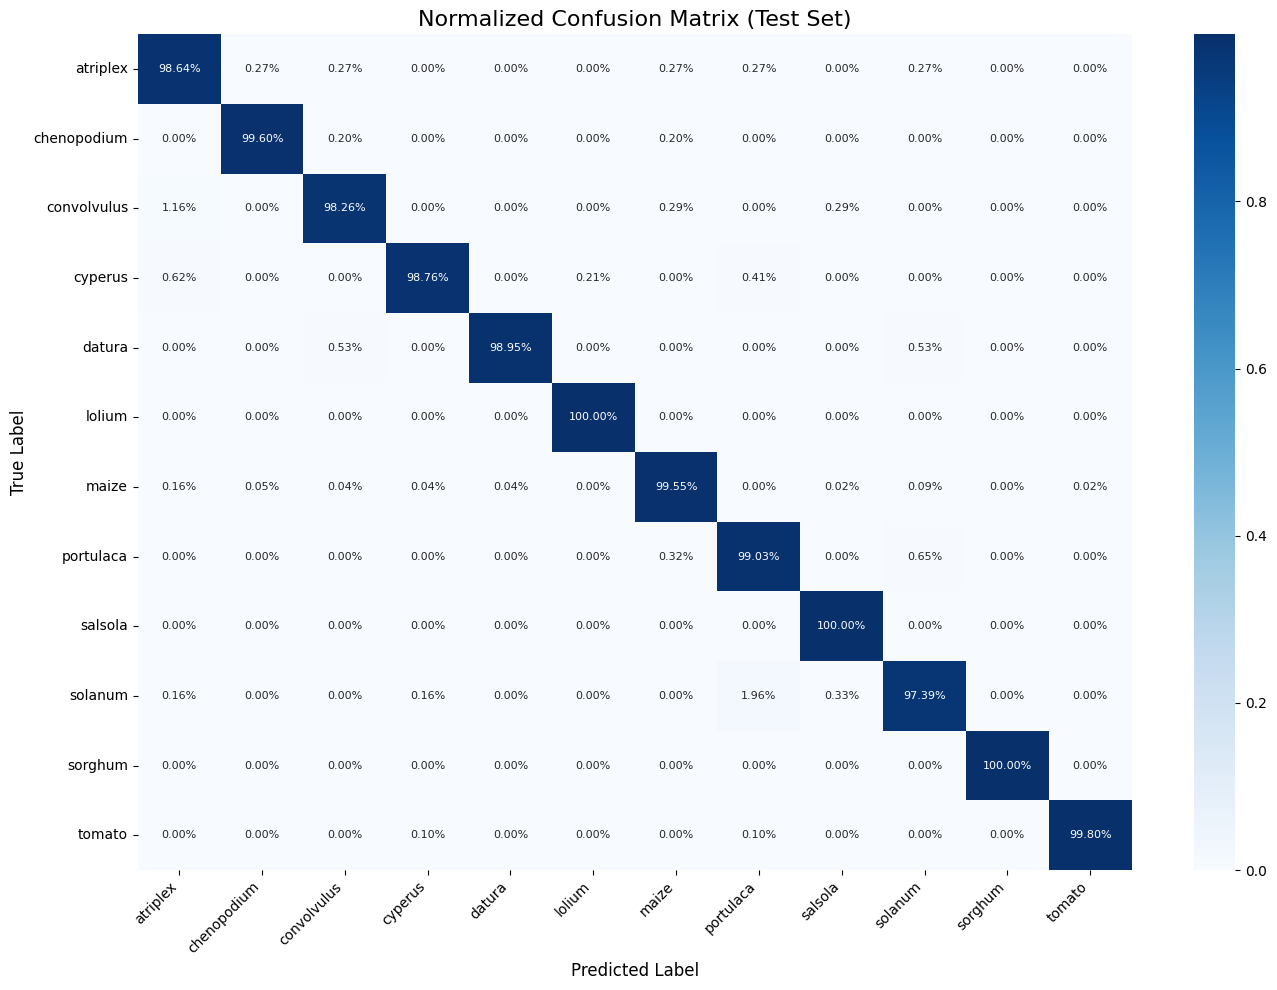


--- Confusion Matrix (Raw Counts) ---
             atriplex  chenopodium  convolvulus  cyperus  datura  lolium  \
atriplex          364            1            1        0       0       0   
chenopodium         0          504            1        0       0       0   
convolvulus         4            0          339        0       0       0   
cyperus             3            0            0      476       0       1   
datura              0            0            1        0     188       0   
lolium              0            0            0        0       0     159   
maize               9            3            2        2       2       0   
portulaca           0            0            0        0       0       0   
salsola             0            0            0        0       0       0   
solanum             1            0            0        1       0       0   
sorghum             0            0            0        0       0       0   
tomato              0            0            0  

In [16]:
print("\n--- 📊 Generating Confusion Matrix ---")

# 1. Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# 2. Create a normalized confusion matrix (percentages)
# We add a small epsilon to avoid division by zero if a class has 0 true samples
cm_normalized = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-6)

# 3. Create a DataFrame for nice labeling
cm_df = pd.DataFrame(cm_normalized,
                     index=class_names,
                     columns=class_names)

# 4. Plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(cm_df,
            annot=True,
            fmt=".2%", # Format as percentage with 2 decimal places
            cmap="Blues",
            cbar=True,
            annot_kws={"size": 8}) # Adjust font size

plt.title('Normalized Confusion Matrix (Test Set)', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\n--- Confusion Matrix (Raw Counts) ---")
# Optionally, print the raw counts
cm_counts_df = pd.DataFrame(cm, index=class_names, columns=class_names)
print(cm_counts_df)


--- 📊 Generating Precision-Recall Curves ---


/tmp/ipython-input-1063832671.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab20", len(class_names))


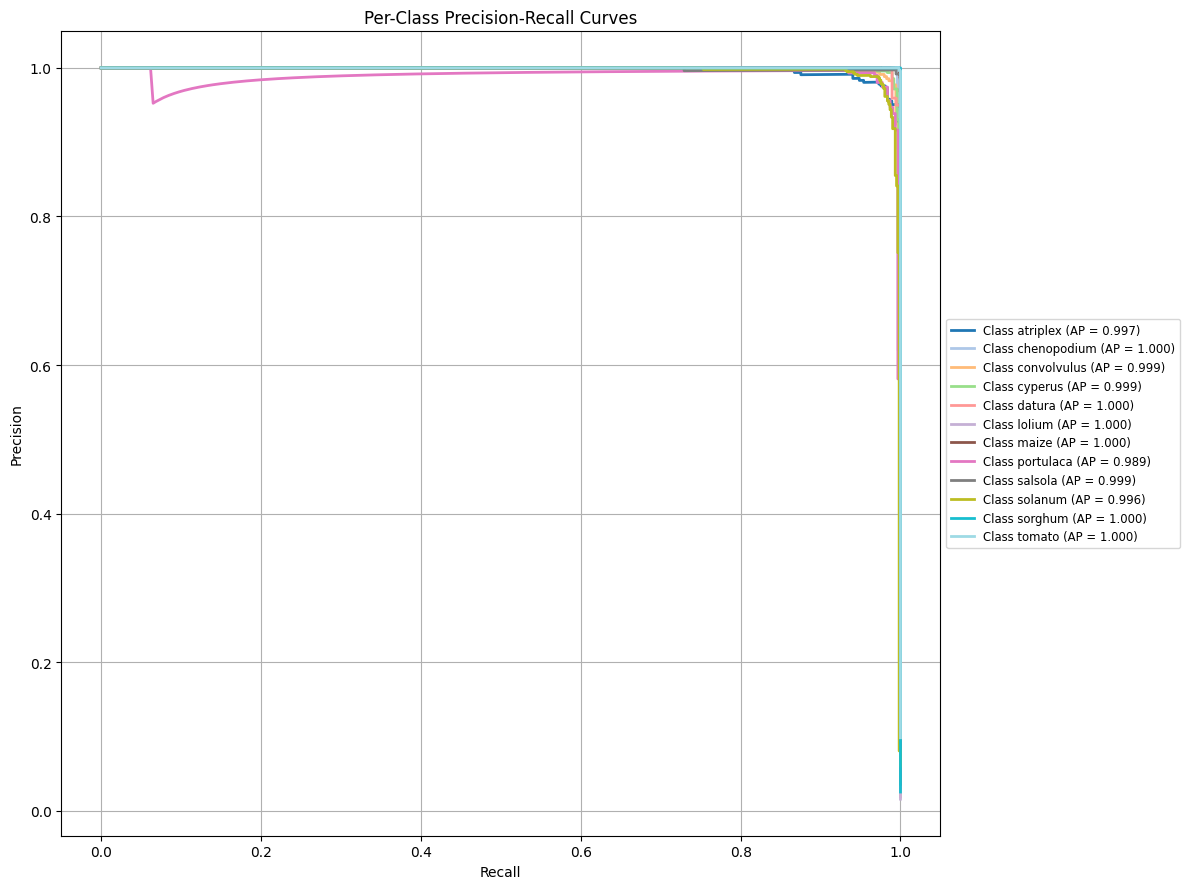

In [17]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

print("\n--- 📊 Generating Precision-Recall Curves ---")

# Binarize the true labels for One-vs-Rest calculation
# This creates a (N_samples, N_classes) array
y_true_binarized = label_binarize(y_true, classes=range(len(class_names)))

# A dictionary to store P-R curve data for each class
precision = dict()
recall = dict()
avg_precision = dict()

# Compute P-R curve and average precision for each class
for i in range(len(class_names)):
    precision[i], recall[i], _ = precision_recall_curve(y_true_binarized[:, i], y_pred_probs[:, i])
    avg_precision[i] = average_precision_score(y_true_binarized[:, i], y_pred_probs[:, i])

# Plot the P-R curves
plt.figure(figsize=(12, 9))
colors = plt.cm.get_cmap("tab20", len(class_names))

for i, color in zip(range(len(class_names)), colors.colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label=f'Class {class_names[i]} (AP = {avg_precision[i]:.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Per-Class Precision-Recall Curves')
# Place legend outside the main plot area
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()


--- 📊 Generating Macro-Averaged ROC Curve ---


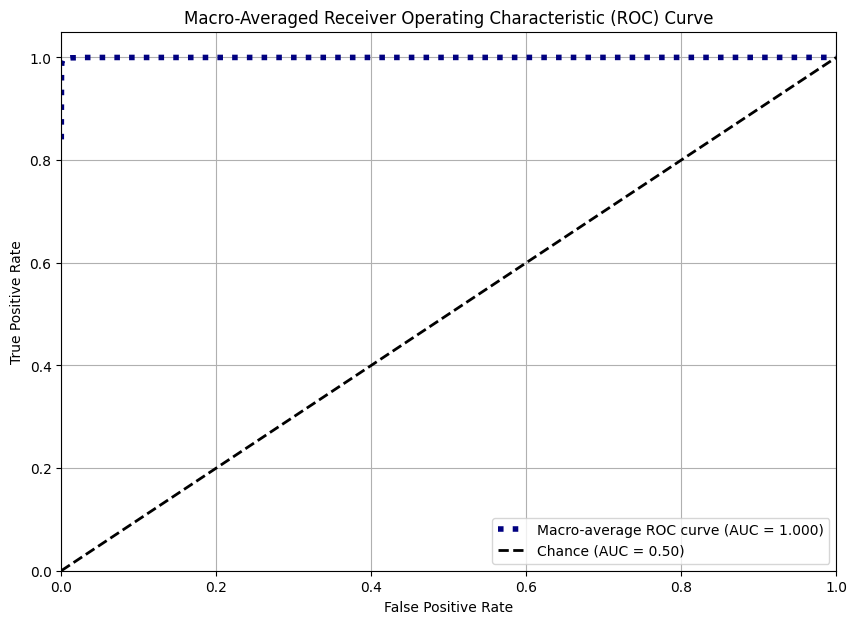

In [18]:
from sklearn.metrics import roc_curve, auc
import numpy as np

print("\n--- 📊 Generating Macro-Averaged ROC Curve ---")

# A dictionary to store ROC curve data
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and ROC area for each class
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# --- Compute Macro-Average ---
# First, aggregate all unique false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(class_names))]))

# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(class_names)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally, average it and compute AUC
mean_tpr /= len(class_names)
macro_roc_auc = auc(all_fpr, mean_tpr)

# --- Plot the Macro-Average ROC ---
plt.figure(figsize=(10, 7))
plt.plot(all_fpr, mean_tpr,
         label=f'Macro-average ROC curve (AUC = {macro_roc_auc:.3f})',
         color='navy', linestyle=':', linewidth=4)

# Plot the "chance" line
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance (AUC = 0.50)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-Averaged Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


--- 📊 Generating F1-Score vs. Support Plot ---


/tmp/ipython-input-2448798109.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Class', y='F1-Score', data=metrics_df, ax=ax1, palette="viridis")
/tmp/ipython-input-2448798109.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Class', y='Support', data=metrics_df, ax=ax2, palette="plasma")


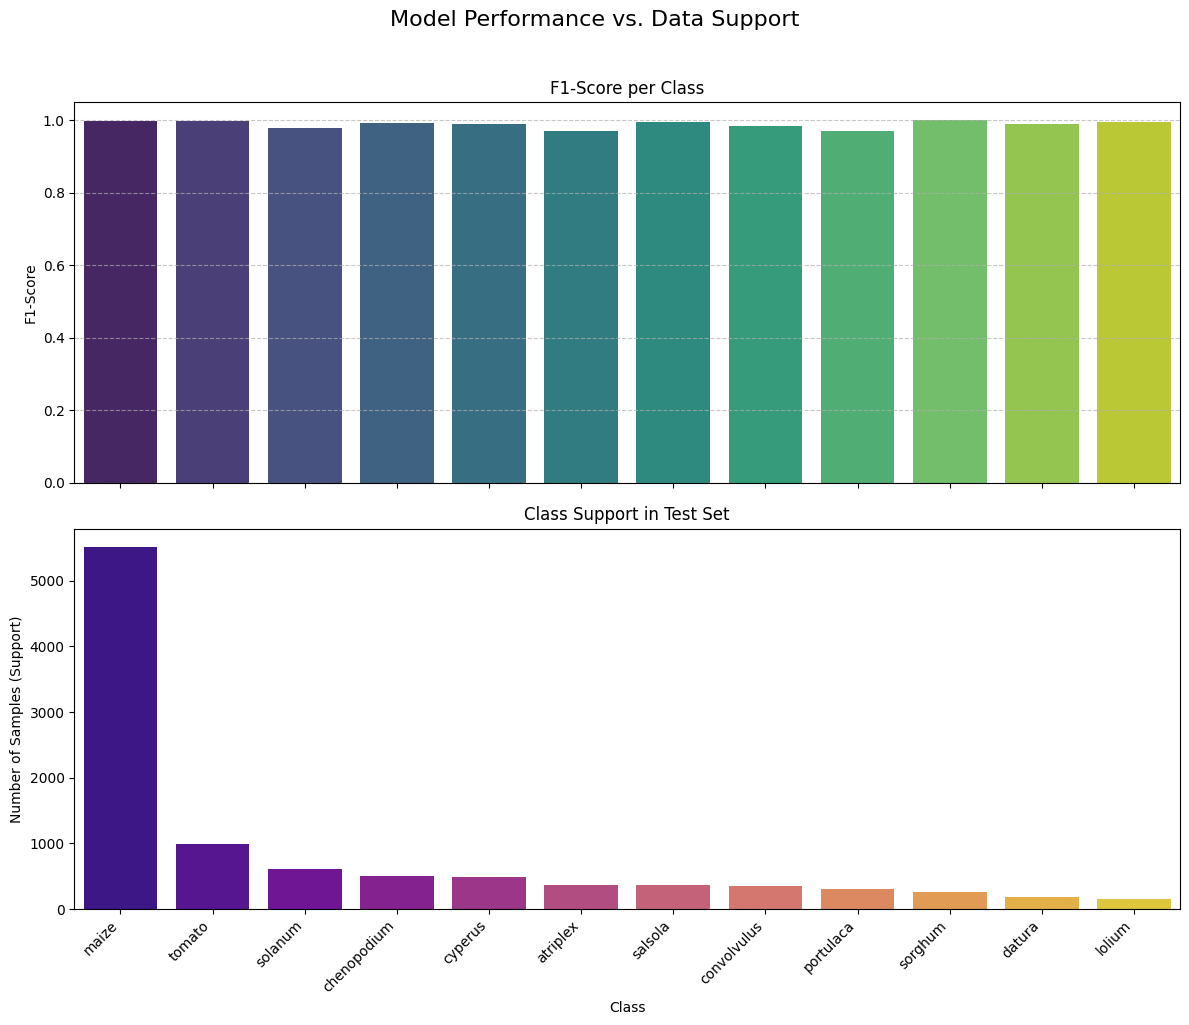

In [19]:
import pandas as pd
from sklearn.metrics import classification_report

print("\n--- 📊 Generating F1-Score vs. Support Plot ---")

# 1. Get F1-scores and support from the classification report
report_dict = classification_report(y_true, y_pred_classes, target_names=class_names, output_dict=True)

# 2. Create a DataFrame
class_metrics = []
for class_name in class_names:
    if class_name in report_dict:
        class_metrics.append({
            'Class': class_name,
            'F1-Score': report_dict[class_name]['f1-score'],
            'Support': report_dict[class_name]['support']
        })

metrics_df = pd.DataFrame(class_metrics).sort_values('Support', ascending=False)

# 3. Plot as two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Subplot 1: F1-Scores
sns.barplot(x='Class', y='F1-Score', data=metrics_df, ax=ax1, palette="viridis")
ax1.set_title('F1-Score per Class')
ax1.set_ylabel('F1-Score')
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Subplot 2: Support (Number of Test Samples)
sns.barplot(x='Class', y='Support', data=metrics_df, ax=ax2, palette="plasma")
ax2.set_title('Class Support in Test Set')
ax2.set_ylabel('Number of Samples (Support)')
ax2.set_xlabel('Class')

# Common formatting
plt.xticks(rotation=45, ha='right')
fig.suptitle('Model Performance vs. Data Support', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


--- 📸 Visualizing Model Predictions ---
Total Correct: 10035
Total Incorrect: 67


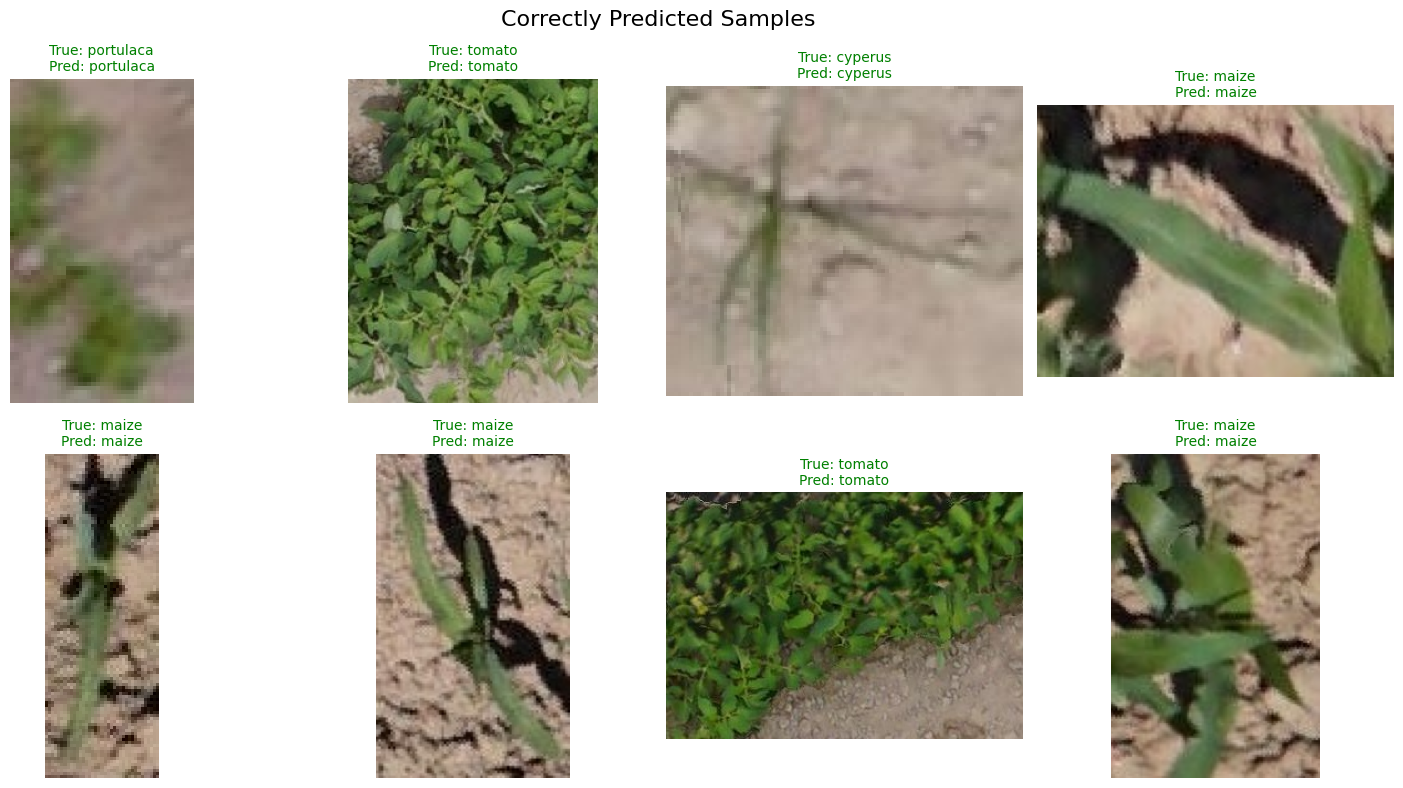

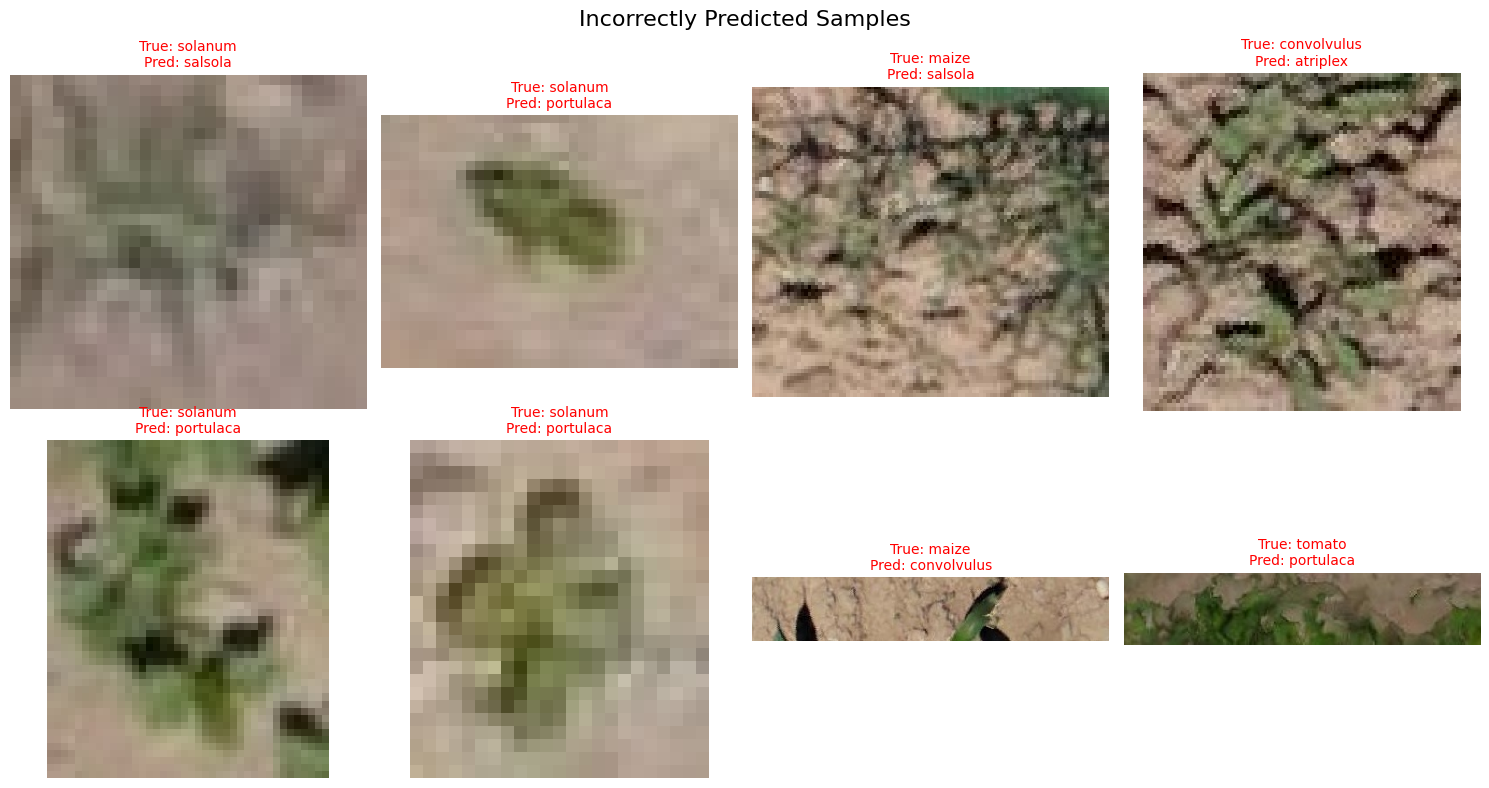

In [20]:
import random
import cv2
import matplotlib.pyplot as plt

print("\n--- 📸 Visualizing Model Predictions ---")

# 1. Find indices for correct and incorrect predictions
correct_indices = []
incorrect_indices = []
for i in range(len(y_true)):
    if y_true[i] == y_pred_classes[i]:
        correct_indices.append(i)
    else:
        incorrect_indices.append(i)

print(f"Total Correct: {len(correct_indices)}")
print(f"Total Incorrect: {len(incorrect_indices)}")

# 2. Randomly sample indices from both lists
num_samples = 8 # We'll show 8 of each
if len(correct_indices) >= num_samples:
    sample_correct_indices = random.sample(correct_indices, num_samples)
else:
    sample_correct_indices = correct_indices # Show all if fewer than num_samples

if len(incorrect_indices) >= num_samples:
    sample_incorrect_indices = random.sample(incorrect_indices, num_samples)
else:
    sample_incorrect_indices = incorrect_indices # Show all if fewer

# --- 3. Plot Correctly Predicted Images ---
fig, axes = plt.subplots(2, 4, figsize=(15, 8)) # 2 rows, 4 columns
fig.suptitle("Correctly Predicted Samples", fontsize=16)

for i, ax in enumerate(axes.flat):
    if i < len(sample_correct_indices):
        # Get the index and path
        idx = sample_correct_indices[i]
        img_path = all_test_paths[idx]

        # Get true and pred labels
        true_label = class_names[y_true[idx]]
        pred_label = class_names[y_pred_classes[idx]]

        # Load and display image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)

        # Set title in green
        ax.set_title(f"True: {true_label}\nPred: {pred_label}", color="green", fontsize=10)
        ax.axis('off')
    else:
        ax.axis('off') # Hide unused subplots

plt.tight_layout()
plt.show()


# --- 4. Plot Incorrectly Predicted Images ---
if sample_incorrect_indices:
    fig, axes = plt.subplots(2, 4, figsize=(15, 8)) # 2 rows, 4 columns
    fig.suptitle("Incorrectly Predicted Samples", fontsize=16)

    for i, ax in enumerate(axes.flat):
        if i < len(sample_incorrect_indices):
            # Get the index and path
            idx = sample_incorrect_indices[i]
            img_path = all_test_paths[idx]

            # Get true and pred labels
            true_label = class_names[y_true[idx]]
            pred_label = class_names[y_pred_classes[idx]]

            # Load and display image
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            ax.imshow(img)

            # Set title with red for the incorrect prediction
            ax.set_title(f"True: {true_label}\nPred: {pred_label}", color="red", fontsize=10)
            ax.axis('off')
        else:
            ax.axis('off') # Hide unused subplots

    plt.tight_layout()
    plt.show()
else:
    print("\nNo incorrectly predicted images to display!")